# Applied Statistics

# Diabetes Deaths

## Survival Analysis

In [ ]:
pip install lifelines

In [ ]:
# loading the data:
import lifelines
df_HF = pd.read_csv('/content/drive/MyDrive/simulated HF mort data for GMPH (1K) final.csv')
df_HF_ = df_HF[['death', 'age', 'diabetes']]
df_HF_.head()

,death,age,diabetes
0,0,90,0
1,0,74,0
2,0,83,0
3,0,79,1
4,0,94,1


<Axes: >

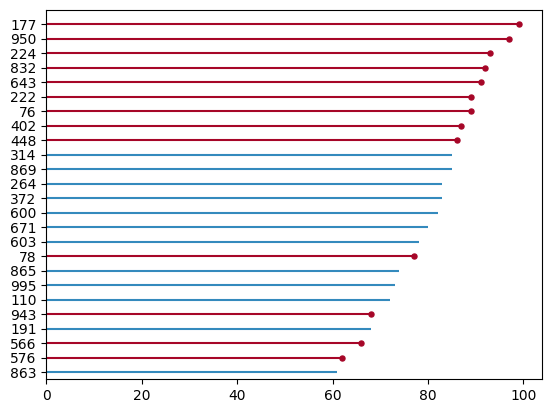

In [ ]:
from lifelines.plotting import plot_lifetimes
df2=df_HF.sample(25)
plot_lifetimes(df2["age"],df2["death"])

<Axes: xlabel='diabetes', ylabel='age'>

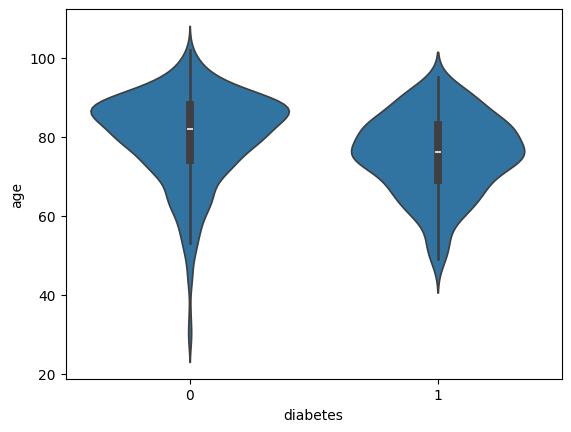

In [ ]:
sns.violinplot(x = 'diabetes', y = 'age', data = df_HF_)

<Axes: xlabel='death', ylabel='age'>

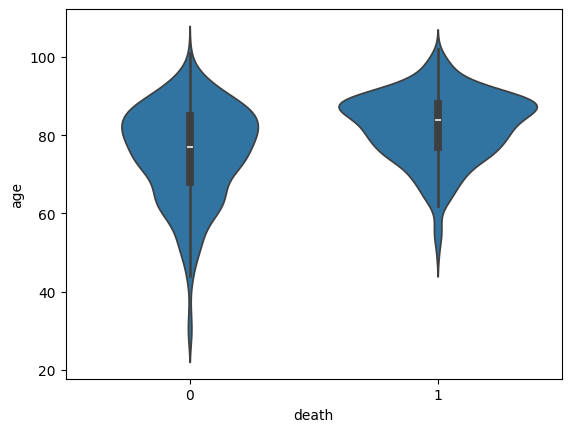

In [ ]:
sns.violinplot(x = 'death', y = 'age', data = df_HF_)

Let's try to find the best fit for an exponential distribution for our data:
When we look only at the dead people.

54.0 29.539944903581272


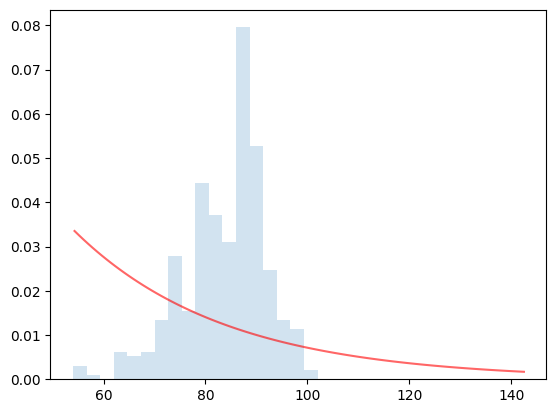

In [ ]:
from scipy.stats import expon
df_subset = df_HF_[(df_HF_['death'] == 1) & (df_HF_['diabetes'] == 0)]
loc, scale = expon.fit(df_subset["age"])
RV = expon(loc,scale)
print(loc, scale)

x = np.linspace(RV.ppf(0.01),RV.ppf(0.95), 100)
plt.plot(x, RV.pdf(x),'r-', alpha=0.6);
plt.hist(df_subset["age"], density=True, bins='auto', histtype='stepfilled', alpha=0.2);

Changing to weibull

(11.72446764762092, 4.420809351144318, 82.62518412156678)


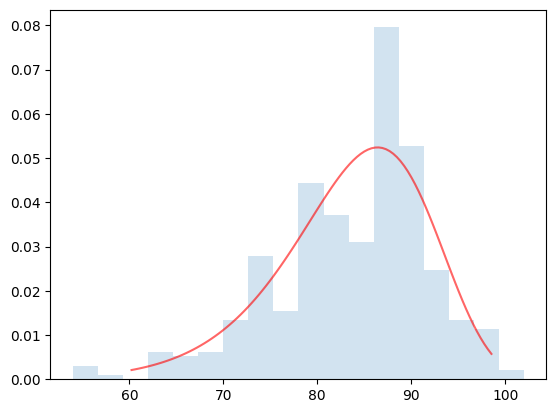

In [ ]:
from scipy.stats import weibull_min
params = weibull_min.fit(df_subset["age"])
RV = weibull_min(*params)
print(params)

x = np.linspace(RV.ppf(0.01),RV.ppf(0.99), 100)
plt.plot(x, RV.pdf(x),'r-', alpha=0.6);
plt.hist(df_subset["age"], density=True, bins='auto', histtype='stepfilled', alpha=0.2);

We can clearly see a better fit.

Using the empirical CDF.

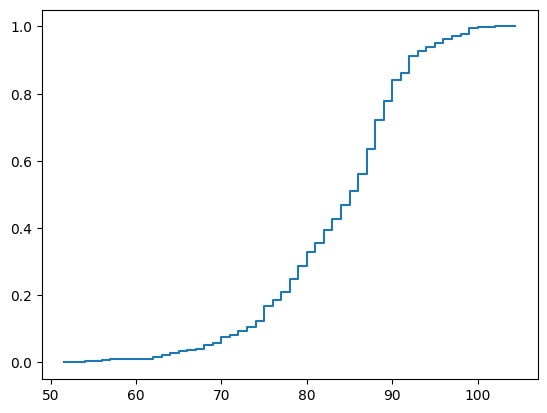

In [ ]:
import scipy.stats
ecdf = scipy.stats.ecdf(df_subset["age"])
ecdf.cdf.plot()

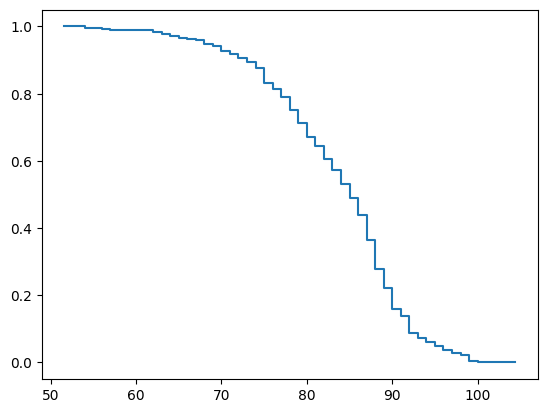

In [ ]:
ecdf.sf.plot()

Now let's add the part of the data of the people still alive

          KM_estimate
timeline             
0.0               1.0
29.0              1.0
30.0              1.0
33.0              1.0
36.0              1.0


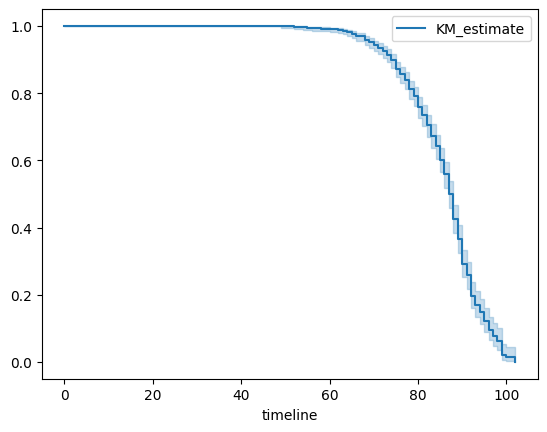

In [ ]:
kmf = lifelines.KaplanMeierFitter()
kmf = kmf.fit(df_HF_["age"], df_HF_["death"])
print(kmf.survival_function_.head())
kmf.plot();

Now we check if there is a clear difference between the control group and the diabetes.

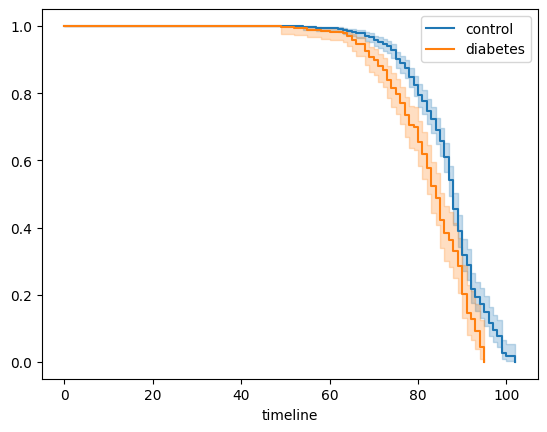

In [ ]:
groups = df_HF_['diabetes']
mir_idx = (groups == 1)

kmf1=lifelines.KaplanMeierFitter()
kmf1.fit(df_HF_[~mir_idx]["age"], df_HF_[~mir_idx]["death"], label='control')
ax = kmf1.plot_survival_function()


kmf2=lifelines.KaplanMeierFitter()
kmf2.fit(df_HF_[mir_idx]["age"], df_HF_[mir_idx]["death"], label='diabetes')
ax = kmf2.plot_survival_function(ax=ax)

Is the control life longer?

In [ ]:
control_lifetimes = df_HF_[df_HF_['diabetes'] == 0]['age']
mir_lifetimes = df_HF_[df_HF_['diabetes'] == 1]['age']

stats.ttest_ind(control_lifetimes, mir_lifetimes)

TtestResult(statistic=5.956254723589902, pvalue=3.572917127206007e-09, df=998.0)

## survival regression

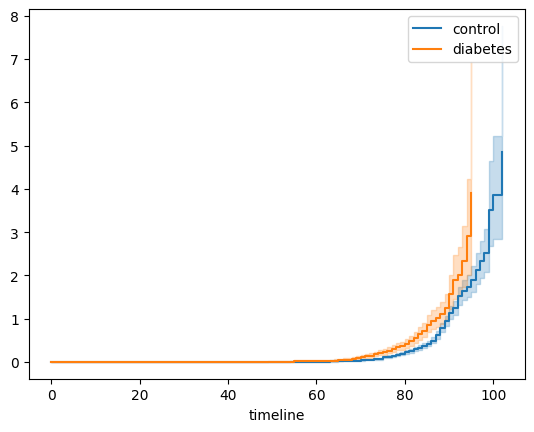

In [ ]:
### not important
naf = lifelines.NelsonAalenFitter()
naf1=lifelines.NelsonAalenFitter()
naf1.fit(df_HF_[~mir_idx]["age"], df_HF_[~mir_idx]["death"], label='control')
ax = naf1.plot_cumulative_hazard()


naf2=lifelines.NelsonAalenFitter()
naf2.fit(df_HF_[mir_idx]["age"], df_HF_[mir_idx]["death"], label='diabetes')
ax = naf2.plot_cumulative_hazard(ax=ax)

Cox regression will give us the best results:

In [ ]:
cph = lifelines.CoxPHFitter()
cph.fit(df_HF_, duration_col="age", event_col="death")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1000 total observations, 508 right-censored observations>
             duration col = 'age'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 492
   partial log-likelihood = -2789.63
         time fit was run = 2024-11-25 20:06:56 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
diabetes   0.55      1.73      0.10            0.34            0.75                1.41                2.12

           cmp to    z      p  -log2(p)
covariate                              
diabetes     0.00 5.22 <0.005     22.40
---
Concordance = 0.56
Partial AIC = 5581.26
log-likelihood ratio test = 25.00 on 1 df
-log2(p) of ll-ratio test = 20.74

We can see that being in the diabetes group makes your hazzared rate only slightly worse


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.0853)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1328)'>]]

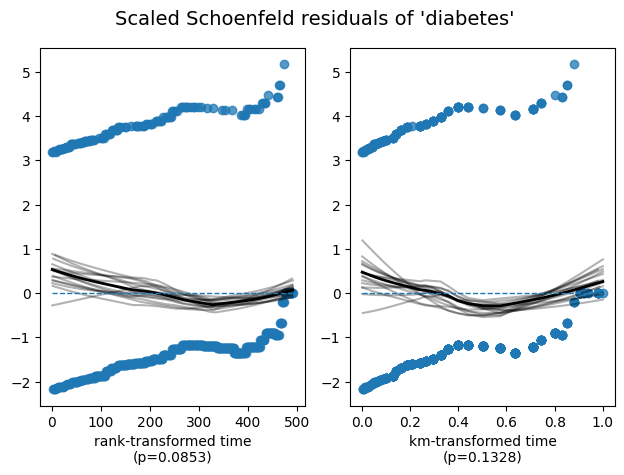

In [ ]:
cph.check_assumptions(df_HF_,show_plots=True)